In [1]:
#| default_exp advanced_wrapping

In [2]:
#| export

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import wrapping as tcwrap

import numpy as np
from copy import deepcopy
import warnings
import igl

from scipy import sparse
import shutil

In [3]:
from tqdm.notebook import tqdm
from importlib import reload

import matplotlib.pyplot as plt

In [763]:
np.set_printoptions(suppress=False)

## Advanced wrapping

In this notebook we present some additional wrapping algorithms. So far, we have wrapped two meshes by simply projection each source mesh vertex onto the closest position on the target mesh. This works, but has drawbacks when there are large, localized deformations.

We can think of the wrapping process like stretching the source surface to fit onto the target surface. The "closest point" method effectively gives the source surface zero elastic resistance during the stretching. This means that small regions will capture all deformations, leading to poor results.

Here, we'll look into alternative algorithms which implement some form of effective elasticity.

#### Loading test data

Let's load the test meshes from the fly midgut

In [6]:
meshes_dict = {i: tcio.read_other_formats_without_uv(f"movie_example/meshes/mesh_{str(i).zfill(2)}.ply")
               for i in tqdm(range(1, 32))}

  0%|          | 0/31 [00:00<?, ?it/s]

In [28]:
mesh_initial_UV = tcio.ObjMesh.read_obj("movie_example/initial_uv.obj")
mesh_final_UV = tcio.ObjMesh.read_obj("movie_example/final_uv.obj") # this is a UV map defined for tpt 20

In [639]:
mesh_60 = tcio.read_other_formats_without_uv(f"movie_example/meshes/mesh_{str(60).zfill(2)}.ply")

### Reverse wrapping

In [13]:
reload(tcwrap)

<module 'blender_tissue_cartography.wrapping' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py'>

In [14]:
t_final = 20
meshes_wrapped_reverse = {20: mesh_final_UV}

In [15]:
for i in tqdm(reversed(range(1, t_final))):
    print(i)
    mesh_source = meshes_wrapped_reverse[i+1]
    mesh_target = meshes_dict[i]
    # register using ICP
    trafo_centroid_intertia, _ = tcreg.align_by_centroid_and_intertia(mesh_source.vertices, mesh_target.vertices,
                                    q=0.01, shear=True, choose_minimal_rotation=True)
    trafo_icp, _, _ = tcreg.icp(mesh_source.vertices, mesh_target.vertices, initial=trafo_centroid_intertia,
                                threshold=1e-4, max_iterations=20, include_scaling=True, n_samples=5000)
    mesh_registered = mesh_source.apply_affine_to_mesh(trafo_icp)
    # shrink-wrap
    mesh_wrapped = tcwrap.shrinkwrap_igl(mesh_registered, mesh_target,
                                         n_iter_smooth_target=2, n_iter_smooth_wrapped=2)
    mesh_wrapped = tcwrap.smooth_laplacian_on_surface(mesh_wrapped, n_iter=5, lamb=0.5, n_iter_laplace=10)
    # append to list
    mesh_wrapped.write_obj(f"movie_example/meshes_wrapped_reverse/mesh_{str(i).zfill(2)}_wrapped_reverse.obj")
    meshes_wrapped_reverse[i] = mesh_wrapped

0it [00:00, ?it/s]

19
18
17
16


/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/blender-tissue-cartography/blender_tissue_cartography/wrapping.py:192: RuntimeWarning: Warning: 2 normal(s) flipped during shrink-wrapping
  return mesh_wrapped


15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


### Adadptive mesh resolution

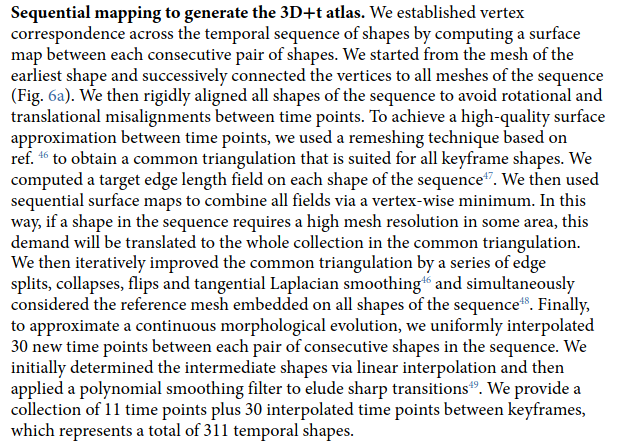

### Conformal methods

- Disk: I can do myself. Use libigl for mapping to unit disk, solve for remaining rotations using spherical harmonics of Laplace Beltrami. In the case of the disk, I think finding a centering Moebius may not be necessary, since harmonic equation with circular boundary conditions

- Sphere: Moebius wrapper. I may be able to implement it myself:
    - Map to sphere by cutting out an arbitrary vertex, mapping to disk, and then doing reverse stereographic
    - Center using Krane Kazhdan algo
    - Align rotations

- arbitrary genus: can use hyperbolic orbifolds https://github.com/noamaig/hyperbolic_orbifolds/. This requires 3-4 interest points /  landmarks. Let's not do this.

### Disk

Following https://libigl.github.io/libigl-python-bindings/tut-chapter4/

In [43]:
def map_to_disk(mesh):
    """
    Map mesh to unit disk by computing harmonic UV coordinates.
    
    The longest boundary loop of the mesh is mapped to the unit circle.
    Follows https://libigl.github.io/libigl-python-bindings/tut-chapter4/.
    
    The disk rotation angle is arbitrary
    
    Parameters
    ----------
    mesh : tcio.ObjMesh
        Mesh. Must be topologically a disk (potentially with holes),
        and should be triangular.
    quantiles : tuple
        Image quantile to set to 0 and 1.
    
    Returns
    -------
    mesh_parametrized : tcio.ObjMesh
        Mesh with UV coordinates mapping it to the disk.

    
    """
    if not mesh.is_triangular:
        warnings.warn("Warning: ignoring non-triangular faces", RuntimeWarning)
    ## Find the open boundary
    bnd = igl.boundary_loop(mesh.tris)
    assert len(bnd) > 0, "No boundary found! Your mesh may not be a disk" 

    ## Map the boundary to a circle, preserving edge proportions
    bnd_uv = igl.map_vertices_to_circle(mesh.vertices, bnd)

    ## Harmonic parametrization for the internal vertices
    uv = igl.harmonic(mesh.vertices, mesh.tris, bnd, bnd_uv, 1)
    uv = uv/2+np.array([0.5, 0.5])
    
    ## create new mesh
    mesh_parametrized = tcio.ObjMesh(vertices=mesh.vertices, texture_vertices=uv, normals=None,
                                faces=[[[v,v] for v in fc] for fc in mesh.tris])
    mesh_parametrized.set_normals()
    
    return mesh_parametrized

In [44]:
mesh = tcio.ObjMesh.read_obj("movie_example/plane_example.obj")

mesh_parametrized = map_to_disk(mesh)

(-0.049841709467476805,
 1.049992462355594,
 -0.04994346724076043,
 1.0496419841918154)

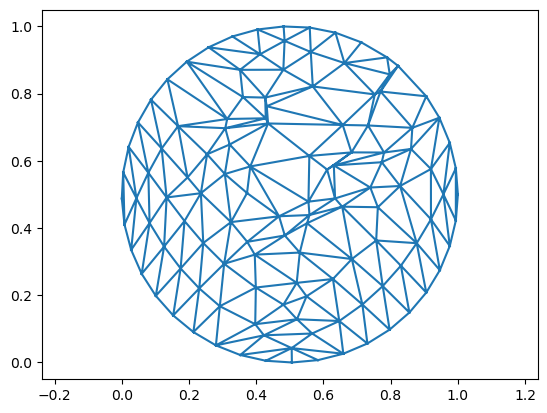

In [98]:
plt.triplot(*mesh_parametrized.texture_vertices.T, mesh_parametrized.texture_tris)
plt.axis("equal")

In [99]:
igl.flipped_triangles(mesh_parametrized.texture_vertices, mesh_parametrized.texture_tris)

array([], shape=(0, 0), dtype=int64)

#### Rotational alignment

The disk can still be rotated freely. I think the "centering" part of Moebius alignment is already done automatically? Use method from Moebius registration paper:

"We next seek the rotation that best aligns the two parameterizations. To do so, we first sample the conformal factors of each mesh onto a regular spherical grid (Figure 6, top right). We then find the rotation that maximizes the correlation between conformal factors, via a fast spectral transform."

In [440]:
from scipy import integrate, interpolate
import matplotlib as mpl
from skimage import registration
from skimage import transform
from scipy import spatial, ndimage

In [374]:
def rot_mat(phi):
    """Get rotation matrix with angle phi"""
    return np.array([[np.cos(phi), np.sin(phi)],[-np.sin(phi), np.cos(phi)]])

In [382]:
mesh_a = deepcopy(mesh_parametrized)
mesh_b = deepcopy(mesh_parametrized)

phi = -0.9*np.pi
mesh_b.texture_vertices = (mesh_a.texture_vertices-np.array([0.5, 0.5]))@rot_mat(phi)+np.array([0.5, 0.5])

(-0.04999841701592133,
 1.0499999246198057,
 -0.0499577122360726,
 1.0499411290933711)

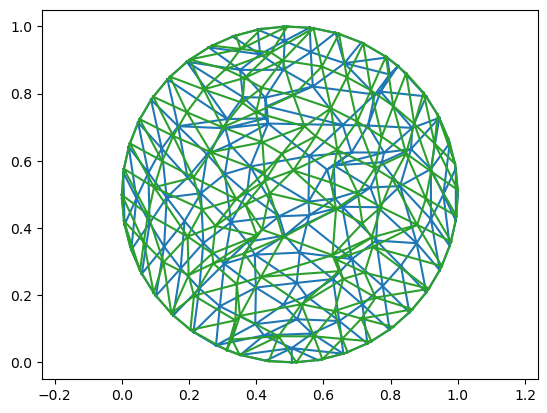

In [383]:
plt.triplot(*mesh_a.texture_vertices.T, mesh_a.texture_tris)

plt.triplot(*mesh_b.texture_vertices.T, mesh_b.texture_tris)
plt.axis("equal")

In [384]:
# for triangle compute the area

In [385]:
def rotational_align_disk(mesh_source, mesh_target, q=0.05, n_grid=256):
    """
    Rotationally align two UV map to the disk by the conformal factor.
    
    Computes aligned UV coordinates. Assumes that the UV
    coordinates are in [0,1]^2. Rotational alignment works by computing
    the conformal factor (how much triangle size changes as it is
    mapped to the plane), which is rotated so that the maximum is at the y-axis
    via a Fourier transform.
    
    Parameters
    ----------
    mesh_source : tcio.ObjMesh
        Mesh. Must be topologically a disk (potentially with holes),
        and should be triangular.
    mesh_target : tcio.ObjMesh
        Mesh. Must be topologically a disk (potentially with holes),
        and should be triangular.
    q : float between 0 and 0.5
        Conformal factors are clipped at this quantile to avoid outliers.
    n_grid : int
        Grid for interpolation of conformal factor during alignment
    
    Returns
    -------
    new_texture_vertices_mesh_source : np.array
        Rotationally aligned texture vertices
    
    """
    assert mesh_source.tris.shape==mesh_source.texture_tris.shape,\
        "3d and UV triangulations must be identical"
    assert (mesh_source.tris==mesh_source.texture_tris).all(),\
        "3d and UV triangulations must be identical"
    assert mesh_target.tris.shape==mesh_target.texture_tris.shape,\
        "3d and UV triangulations must be identical"
    assert (mesh_target.tris==mesh_target.texture_tris).all(),\
        "3d and UV triangulations must be identical"
    # compute conformal distortion factors, clip to avoid outliers
    conformal_factor_source = (igl.doublearea(mesh_source.vertices, mesh_source.tris)/
                               igl.doublearea(mesh_source.texture_vertices, mesh_source.texture_tris))
    conformal_factor_source = np.clip(conformal_factor_source, np.quantile(conformal_factor_source, q),
                                      np.quantile(conformal_factor_source, 1-q))
    uv_centroids_source = mesh_source.texture_vertices[mesh_source.texture_tris].mean(axis=1)
    conformal_factor_target = (igl.doublearea(mesh_target.vertices, mesh_target.tris)/
                               igl.doublearea(mesh_target.texture_vertices, mesh_target.texture_tris))
    conformal_factor_target = np.clip(conformal_factor_target, np.quantile(conformal_factor_target, q),
                                      np.quantile(conformal_factor_target, 1-q))
    uv_centroids_target = mesh_target.texture_vertices[mesh_target.texture_tris].mean(axis=1)
    # interpolate onto a grid
    U, V = np.meshgrid(*2*[np.linspace(0, 1, n_grid)])
    conformal_factor_source = igl.average_onto_vertices(mesh_source.vertices, mesh_source.texture_tris,
                                                        np.stack(3*[conformal_factor_source], axis=-1))[:,0]
    conformal_factor_target = igl.average_onto_vertices(mesh_target.vertices, mesh_target.texture_tris,
                                                        np.stack(3*[conformal_factor_target], axis=-1))[:,0]
    interpolated_source = mpl.tri.LinearTriInterpolator(mpl.tri.Triangulation(*mesh_source.texture_vertices.T,
                                                                              mesh_source.texture_tris),
                                                        conformal_factor_source)(U,V)
    interpolated_target = mpl.tri.LinearTriInterpolator(mpl.tri.Triangulation(*mesh_target.texture_vertices.T,
                                                                              mesh_target.texture_tris),
                                                        conformal_factor_target)(U,V)
    # compute rotational alignment
    interpolated_source_polar = transform.warp_polar(interpolated_source, radius=n_grid/2-1)
    interpolated_target_polar = transform.warp_polar(interpolated_target, radius=n_grid/2-1)

    shifts, _, _ = registration.phase_cross_correlation(interpolated_source_polar, interpolated_target_polar,
                                                        reference_mask=~np.isnan(interpolated_source_polar),
                                                        moving_mask=~np.isnan(interpolated_target_polar),
                                                        normalization=None)

    rot_angle = shifts[0]*np.pi/180
    new_texture_vertices = (mesh_source.texture_vertices-np.array([0.5,0.5]))@rot_mat(-rot_angle)
    new_texture_vertices += np.array([0.5,0.5])
    return new_texture_vertices

In [386]:
mesh_a.texture_vertices = rotational_align_disk(mesh_a, mesh_b)

(-0.04998929656244213,
 1.0498083950967414,
 -0.04959209436449739,
 1.0499237187185342)

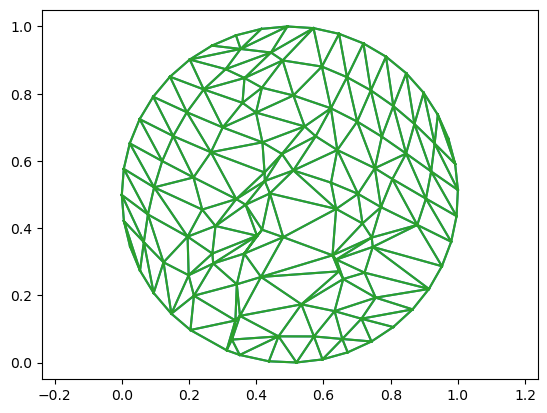

In [387]:
plt.triplot(*mesh_a.texture_vertices.T, mesh_a.texture_tris)

plt.triplot(*mesh_b.texture_vertices.T, mesh_b.texture_tris)
plt.axis("equal")

In [ ]:
# one must be careful with bdry!

### Mesh registration

In [389]:
from scipy import stats

In [390]:
mesh_source = tcio.ObjMesh.read_obj("movie_example/plane_example.obj")
mesh_target = deepcopy(mesh_source)

random_rot = stats.special_ortho_group.rvs(3)
mesh_target.vertices = mesh_target.vertices@random_rot + np.array([2, 9, 1])

In [556]:
import skfmm

In [594]:
def extrapolate_fast_marching(arr):
    """Fill nans in 2d numpy array via fast-marching extrapolation."""
    mask = ~ndimage.binary_erosion(~np.isnan(arr), iterations=2)
    extended = skfmm.extension_velocities(mask, arr)[1]
    return extended

In [ ]:
# now interpolate the 3d vertex positons. special care needed at the bdry.
# hence, instead of interpolating directly, we first interpolate onto a grid

In [626]:
def wrap_coords_via_disk(mesh_source, mesh_target, n_grid=512):
    """
    Map 3d coords of source mesh to target mesh via a disk parametrization. 
    
    """
    # compute harmonic map to disk
    mesh_source_disk = map_to_disk(mesh_source)
    mesh_target_disk = map_to_disk(mesh_target)
    # rotational alignment of parametrizations
    mesh_source_disk.texture_vertices = rotational_align_disk(mesh_source_disk, mesh_target_disk)
    # interpolate 3d coordinates. we use a grid and extend the interpolated UV coordinates
    # to the whole UV square in order to avoid issues with the disk boundary.
    U, V = np.meshgrid(*2*[np.linspace(0, 1, n_grid)])
    triangulation_target = mpl.tri.Triangulation(*mesh_target_disk.texture_vertices.T,
                                                 mesh_target_disk.texture_tris)
    interpolators = [mpl.tri.LinearTriInterpolator(triangulation_target, x) for x in mesh_target_disk.vertices.T]
    interpolated = np.stack([extrapolate_fast_marching(np.array(f(U, V))) for f in interpolators], axis=0)
    # interpolate onto source mesh
    new_coords = np.stack([interpolate.interpn((U[0], V[:,0]), x, mesh_source_disk.texture_vertices[:,::-1])
                           for x in interpolated], axis=-1)
    return new_coords

In [624]:
mesh_source = tcio.ObjMesh.read_obj("movie_example/plane_example.obj")
mesh_target = deepcopy(mesh_source)

random_rot = stats.special_ortho_group.rvs(3)
mesh_target.vertices = mesh_target.vertices@random_rot + np.array([2, 9, 1])

In [628]:
new_coords = wrap_coords_via_disk(mesh_source, mesh_target)

In [629]:
np.linalg.norm(new_coords-mesh_target.vertices, axis=-1).mean()

0.006916452550092062

In [630]:
np.linalg.norm(mesh_source.vertices-mesh_target.vertices, axis=-1).mean()

9.390784186476019

In [634]:
def wrap_coords_via_disk_no_skfmm(mesh_source, mesh_target):
    """
    Map 3d coords of source mesh to target mesh via a disk parametrization. 
    
    """
    # compute harmonic map to disk
    mesh_source_disk = map_to_disk(mesh_source)
    mesh_target_disk = map_to_disk(mesh_target)
    # rotational alignment of parametrizations
    mesh_source_disk.texture_vertices = rotational_align_disk(mesh_source_disk, mesh_target_disk)
    # interpolate 3d coordinates
    triangulation_target = mpl.tri.Triangulation(*mesh_target_disk.texture_vertices.T,
                                                 mesh_target_disk.texture_tris)
    interpolators = [mpl.tri.LinearTriInterpolator(triangulation_target, z) for z in mesh_target_disk.vertices.T]
    interpolated = np.stack([np.array(f(*mesh_source_disk.texture_vertices.T)) for f in interpolators], axis=-1)
    # fix issues due to the boundary - there may be texture vertices of the source mesh
    # we first fix all the boundary vertices which are nan by interpolating from the two closest target boundary pts
    bnd_source = igl.boundary_loop(mesh_source_disk.texture_tris)
    bnd_target = igl.boundary_loop(mesh_target_disk.texture_tris)
    tree = spatial.cKDTree(mesh_target_disk.texture_vertices[bnd_target])
    dists, inds = tree.query(mesh_source_disk.texture_vertices[bnd_source], k=2)
    dists = (dists.T / dists.sum(axis=1)).T
    interpolated_bdry = (mesh_target_disk.vertices[bnd_target][inds].T * dists.T).sum(axis=1).T
    nan_and_bdry = np.isnan(interpolated[bnd_source]).any(axis=1)
    interpolated_bdry[~nan_and_bdry] = interpolated[bnd_source][~nan_and_bdry]
    interpolated[bnd_source] = interpolated_bdry
    # now there still may be interior vertices which are nan. we fix them via a second round of interpolation
    if np.isnan(interpolated).any():
        mask = ~np.isnan(interpolated).any(axis=-1)
        missing = np.stack([interpolate.LinearNDInterpolator(mesh_source_disk.texture_vertices[mask], x[mask])(
            mesh_source_disk.texture_vertices[~mask]) for x in interpolated.T], axis=-1)
        interpolated[~mask] = missing
    return interpolated

In [635]:
new_coords_no_skfmm = wrap_coords_via_disk_no_skfmm(mesh_source, mesh_target)

In [636]:
np.linalg.norm(new_coords_no_skfmm-mesh_target.vertices, axis=-1).mean()

0.026538135555700282

### Sphere

- Cut sphere to disk by removing a single vertex
- Map disk to plane using harmonic coordinates
- Map disk to sphere using stereographic projection
- center using moebius alg

### TO DO - check whether libigl harmonic is a conformal parametrization!

In [1016]:
from scipy import optimize

In [1234]:
#mesh = deepcopy(mesh_initial_UV)
mesh = deepcopy(mesh_final_UV)

In [1235]:
if not mesh.is_triangular:
    warnings.warn("Warning: ignoring non-triangular faces", RuntimeWarning)
# remove "north pole" - by convention, the last vertex in the mesh
north_pole = mesh.vertices.shape[0]-1
faces_all = mesh.tris
tri_mask = (faces_all==north_pole).any(axis=1) 
faces_disk = faces_all[~tri_mask]
vertices_disk = mesh.vertices[:-1]
## Find the open boundary
bnd = igl.boundary_loop(faces_disk)

## don't use harmonic parametrization - it's not conformal.
## Map the boundary to a circle, preserving edge proportions. Use a large value of R to avoid floating pt issues
#R = 1
#bnd_uv = R*igl.map_vertices_to_circle(vertices_disk, bnd)
### Harmonic parametrization for the internal vertices
#uv = igl.harmonic(vertices_disk, faces_disk, bnd, bnd_uv, 1)

## least squares conformal map
bnd = igl.boundary_loop(faces_disk)

b = np.array([bnd[0], bnd[int(np.round(len(bnd)/2))]])
bc = np.array([[0.0, -1.0], [0.0, 1.0]])

# LSCM parametrization
_, uv = igl.lscm(vertices_disk, faces_disk, b, bc)
uv = uv-uv.mean(axis=0)

In [1236]:
igl.doublearea(uv, faces_disk).min()

4.813651254350184e-14

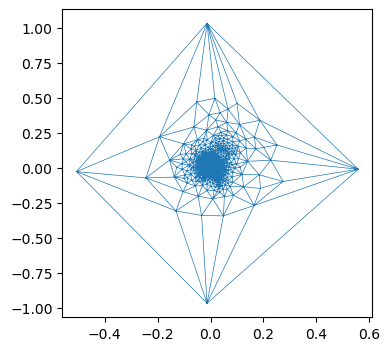

In [1237]:
fig = plt.figure(figsize=(4,4))

plt.triplot(*uv.T, faces_disk, lw=0.5)

In [1238]:
def stereographic_plane_to_sphere(uv):
    """
    Stererographic projection from plane to unit sphere from north pole (0,0,1).
    
    See https://en.wikipedia.org/wiki/Stereographic_projection.
    Convention: plane is at z=0, unit sphere centered at origin.
    uv should be an array of shape (..., 2)
    """
    return (np.stack([2*uv[:,0], 2*uv[:,1], uv[:,0]**2+uv[:,1]**2-1], axis=0) / (1+uv[:,0]**2+uv[:,1]**2)).T
    
def stereographic_sphere_to_plane(pts):
    """
    Stererographic projection from unit sphere to plane from north pole (0,0,1).
    
    See https://en.wikipedia.org/wiki/Stereographic_projection.
    Convention: plane is at z=0, unit sphere centered at origin.
    pts should be an array of shape (..., 3)
    """
    assert np.allclose(np.linalg.norm(pts, axis=1), 1, rtol=1e-03, atol=1e-04), "Points not on unit sphere!"
    return (np.stack([pts[:,0], pts[:,1]], axis=0)/(1-pts[:,2])).T


In [1239]:
np.allclose(np.linalg.norm(stereographic_plane_to_sphere(uv), axis=1), 1)

True

In [1240]:
np.allclose(stereographic_sphere_to_plane(stereographic_plane_to_sphere(uv)), uv)

True

In [1262]:
## map the disk to the sphere using stereographic projection. 

## we can choose the disk radius - let's make it so that it leads to minimal area distortion

areas = igl.doublearea(mesh.vertices, faces_all)
areas = (areas/areas.mean())

def get_distoration(R):
    """
    Measure area distortion as function of disk radius.
    """
    coords_sphere = np.vstack([stereographic_plane_to_sphere(R*uv), np.array([0,0,1])])
    areas_sphere = igl.doublearea(coords_sphere, faces_all)
    areas_sphere = (areas_sphere/areas_sphere.mean())
    distortion = np.log(areas_sphere/areas)
    return np.abs(distortion).mean()

R_opt = optimize.minimize_scalar(get_distoration, bracket=(0.1, 1e4)).x
print(R_opt)
coords_sphere = np.vstack([stereographic_plane_to_sphere(R_opt*uv), np.array([0,0,1])])

172.2247951362335


In [1263]:
tcio.ObjMesh(vertices=coords_sphere, faces=faces_all).write_obj("movie_example/map_to_sphere.obj")
# looks ok

### Moebius centering algorithm

Algorithm 1 from https://www.cs.cmu.edu/~kmcrane/Projects/MobiusRegistration/paper.pdf

In [1264]:
## initialize
Vs = np.copy(coords_sphere)
error = []
n_iter = 1000

for i in tqdm(range(n_iter)):
    ## compute area
    As = igl.doublearea(Vs, faces_all)
    As /= As.sum()

    Cs = Vs[faces_all].mean(axis=1)
    Cs = (Cs.T/np.linalg.norm(Cs,axis=-1)).T
    mu = (As*Cs.T).sum(axis=1)
    error.append(np.linalg.norm(mu))

    ## compute Jacobian and get inversion center
    J = (As*(np.eye(3) - np.einsum('vi,vj->vij', Cs, Cs)).T).sum(axis=-1)
    c = -np.linalg.inv(J)@mu
    
    ## compute inversion
    Vs = ((1-np.linalg.norm(c)**2)*(Vs+c).T /np.linalg.norm(Vs+c, axis=1)**2).T + c
    print(error[-1])

  0%|          | 0/1000 [00:00<?, ?it/s]

3.3434488460217836e-05
3.341538440183718e-05
3.339629377686997e-05
3.337721657277969e-05
3.3358152779661164e-05
3.333910237935087e-05
3.332006536355447e-05
3.330104172495786e-05
3.3282031442965775e-05
3.326303451326863e-05
3.32440509181241e-05
3.322508064908272e-05
3.320612369248708e-05
3.318718003602198e-05
3.316824966812476e-05
3.314933257997385e-05
3.313042875368829e-05
3.311153818408297e-05
3.309266085379459e-05
3.307379675263719e-05
3.3054945872064815e-05
3.3036108196194585e-05
3.301728371080296e-05
3.299847241136193e-05
3.297967428011394e-05
3.296088930957643e-05
3.2942117484088285e-05
3.2923358794783566e-05
3.2904613229729646e-05
3.2885880777204474e-05
3.2867161419477925e-05
3.284845515367907e-05
3.282976196446179e-05
3.28110818408021e-05
3.279241476925804e-05
3.2773760738884145e-05
3.275511973752841e-05
3.273649176075068e-05
3.271787678311158e-05
3.269927480446482e-05
3.26806858055292e-05
3.266210978320518e-05
3.2643546717005386e-05
3.2624996602762404e-05
3.260645942596902e-05


2.719148743727925e-05
2.7176631665076265e-05
2.7161785664616884e-05
2.714694942151797e-05
2.7132122931746522e-05
2.7117306184472343e-05
2.7102499173515933e-05
2.7087701891909506e-05
2.707291432860155e-05
2.7058136479111064e-05
2.7043368330906582e-05
2.702860988184551e-05
2.701386111926722e-05
2.6999122036231916e-05
2.6984392627438094e-05
2.6969672882290382e-05
2.6954962791079602e-05
2.694026234925919e-05
2.6925571545714562e-05
2.6910890379083198e-05
2.6896218832823296e-05
2.6881556903678536e-05
2.6866904586130302e-05
2.6852261867574994e-05
2.6837628740072885e-05
2.682300520080578e-05
2.6808391237138526e-05
2.6793786842056103e-05
2.677919200994765e-05
2.676460673106948e-05
2.6750030997867382e-05
2.6735464801845864e-05
2.6720908137162138e-05
2.6706360994622163e-05
2.669182336453818e-05
2.6677295242232577e-05
2.666277662096799e-05
2.6648267492330227e-05
2.66337678413766e-05
2.6619277669669508e-05
2.660479696422355e-05
2.6590325721800177e-05
2.6575863931530646e-05
2.6561411582961352e-05
2.

2.2136607832740245e-05
2.212498093707451e-05
2.2113361250083832e-05
2.2101748759961362e-05
2.2090143467772893e-05
2.2078545363273e-05
2.20669544436675e-05
2.205537070137443e-05
2.2043794133453718e-05
2.2032224731860378e-05
2.202066249011346e-05
2.2009107407189044e-05
2.199755947738065e-05
2.198601868973008e-05
2.197448504388251e-05
2.1962958533024218e-05
2.1951439153029368e-05
2.1939926892951783e-05
2.1928421755068004e-05
2.1916923729656495e-05
2.1905432811672936e-05
2.1893948994765954e-05
2.188247227781782e-05
2.1871002649623767e-05
2.1859540110196136e-05
2.1848084652527506e-05
2.1836636269617914e-05
2.182519495271692e-05
2.1813760706166576e-05
2.1802333516422046e-05
2.1790913380879292e-05
2.1779500291912965e-05
2.1768094252053908e-05
2.175669524445303e-05
2.1745303274982804e-05
2.173391832812566e-05
2.1722540405855623e-05
2.171116949877809e-05
2.1699805605599716e-05
2.1688448716046748e-05
2.1677098831072188e-05
2.1665755937195517e-05
2.165442003620588e-05
2.1643091119622917e-05
2.163

In [1265]:
np.linalg.norm(Vs,axis=-1)

array([1., 1., 1., ..., 1., 1., 1.])

In [1266]:
np.linalg.norm(c)

2.9236030797788767e-05

In [1267]:
# get the area distortion. did it go down?

In [1268]:
areas_3d = igl.doublearea(mesh.vertices, faces_all)
areas_3d = (areas_3d/areas_3d.mean())

areas_sphere = igl.doublearea(coords_sphere, faces_all)
areas_sphere = (areas_sphere/areas_sphere.mean())
distortion = np.log(areas_sphere/areas_3d)
print(np.abs(distortion).mean())

areas_sphere_post = igl.doublearea(Vs, faces_all)
areas_sphere_post = (areas_sphere_post/areas_sphere_post.mean())
distortion_post = np.log(areas_sphere_post/areas_3d)
print(np.abs(distortion_post).mean())

1.8426167770767743
1.813579876495419


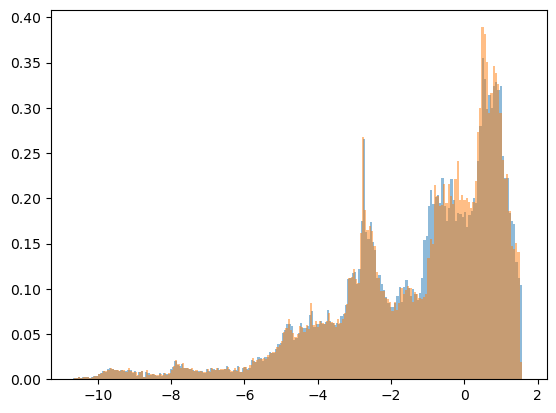

In [1269]:
plt.hist(distortion, density=True, bins=200, alpha=0.5);
plt.hist(distortion_post, density=True, bins=200, alpha=0.5);

In [1270]:
tcio.ObjMesh(vertices=Vs, faces=faces_all).write_obj("movie_example/map_to_sphere_centered.obj")


### Spherical harmonics

- Option 1: interpolate onto $(\theta, \phi)$ grid and use fast spherical harmonics transform
- Option 2: compute spherical harmonics by direct integration

In [1300]:
from scipy import special

In [1331]:
coords_centered = np.copy(Vs)
areas_3d = igl.doublearea(mesh.vertices, faces_all)
areas_sphere = igl.doublearea(coords_centered, faces_all)

conformal_factor = areas_sphere/areas_3d

# following https://en.wikipedia.org/wiki/Spherical_coordinate_system convention

centroids = coords_centered[faces_all].mean(axis=1)
theta = np.arccos(centroids[:,2]/np.linalg.norm(centroids, axis=1))
phi = np.sign(centroids[:,1])*np.arccos(centroids[:,0]/np.linalg.norm(centroids[:,:2], axis=1))

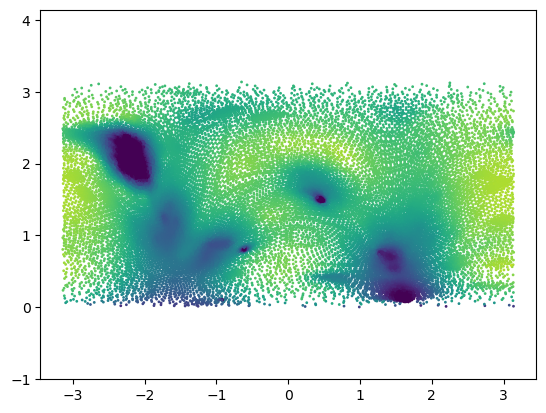

In [1332]:
plt.scatter(phi, theta, c=np.log(conformal_factor/conformal_factor.mean()), s=1, vmin=-2, vmax=2)
plt.axis("equal");

In [1326]:
log_normalized = np.log(conformal_factor)
log_normalized -= log_normalized.mean()

weights = igl.doublearea(coords_centered, faces_all)
weights /= weights.sum()

max_n = 10
spherical_harmonics_coeffs = np.nan*np.zeros((max_n,max_n), dtype="complex_")
for n in range(max_n):
    for m in range(0, n):
        spherical_harmonics_coeffs[n, m] = np.sum(weights*log_normalized*special.sph_harm(m, n, theta, phi))

In [1341]:
rot_mat = stats.special_ortho_group.rvs(3)
rot_mat

array([[-0.11519598, -0.3662708 ,  0.9233502 ],
       [-0.84007681,  0.53196801,  0.10621201],
       [-0.53009513, -0.76344989, -0.36897618]])

In [1348]:
coords_centered_rotated = np.copy(Vs) @ rot_mat
areas_3d = igl.doublearea(mesh.vertices, faces_all)
areas_sphere_rotated  = igl.doublearea(coords_centered_rotated , faces_all)

conformal_factor_rotated  = areas_sphere_rotated/areas_3d

# following https://en.wikipedia.org/wiki/Spherical_coordinate_system convention

centroids_rotated  = coords_centered_rotated[faces_all].mean(axis=1)
theta_rotated  = np.arccos(centroids_rotated[:,2]/np.linalg.norm(centroids_rotated, axis=1))
phi_rotated  = np.sign(centroids_rotated[:,1])*np.arccos(centroids_rotated[:,0]
                                                         /np.linalg.norm(centroids_rotated[:,:2], axis=1))

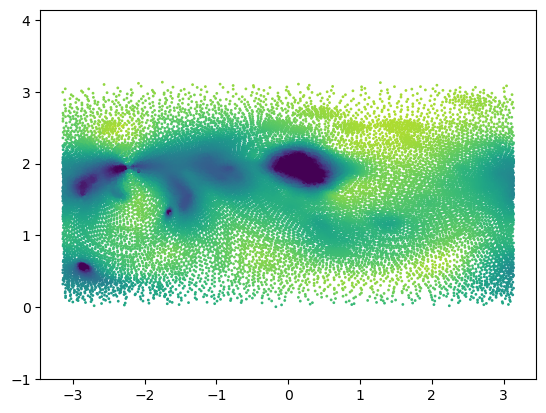

In [1349]:
plt.scatter(phi_rotated, theta_rotated, c=np.log(conformal_factor_rotated/conformal_factor_rotated.mean()),
            s=1, vmin=-2, vmax=2)
plt.axis("equal");

In [1353]:
log_normalized_rotated = np.log(conformal_factor_rotated)
log_normalized_rotated -= log_normalized_rotated.mean()

weights_rotated = igl.doublearea(coords_centered_rotated, faces_all)
weights_rotated /= weights_rotated.sum()

max_n = 10
spherical_harmonics_coeffs_rotated = np.nan*np.zeros((max_n,max_n), dtype="complex_")
for n in range(max_n):
    for m in range(0, n):
        spherical_harmonics_coeffs_rotated[n, m] = np.sum(weights_rotated*log_normalized_rotated
                                                          *special.sph_harm(m, n, theta_rotated, phi_rotated))

## Moebius wrapper

## Stuff that did not work out well

### Thin-plate spline registration

Decided not to bother.

### Non-rigid ICP

Try it out first using trimesh, then do myself to avoid dependency. Use `trimesh.registration.nricp_sumner`


-> No good, takes forever and my laptop runs out of memory. Also lots of parameters to tune whose meaning I don't know.

### Laplace Beltrami based

Idea - compute the eigenfunctions $\phi_i$ of the Laplace operator $\Delta$ on the surface, and the embed each point $p$ on the surface as $p\mapsto \phi_i(p)/\sqrt{\lambda_i}$. 

Works "ok" - in the sense that eigenfunctions 1-3 give a non-degenerate looking surface in 3d - for initial gut which looks not so different from a sphere. Late gut becomes extremely elongated / thin in spectral embedding. 

Not suitable.

See https://www.cs.jhu.edu/~misha/ReadingSeminar/Papers/Rustamov07.pdf, https://web.archive.org/web/20100626223753id_/http://www.cs.jhu.edu/~misha/Fall07/Notes/Rustamov07.pdf

In [7]:
mesh = mesh_initial_UV
laplacian = igl.cotmatrix(mesh.vertices, mesh.tris)
mass = igl.massmatrix(mesh.vertices, mesh.tris)

In [8]:
%%time
#eigen_vals, eigen_vecs = sparse.linalg.eigsh(-laplacian, k=20, ncv=100, which="SM")
eigen_vals, eigen_vecs = sparse.linalg.eigsh(-laplacian, M=mass, k=10, ncv=100, which="SM")

eigen_vals, eigen_vecs = (eigen_vals[1:], eigen_vecs[:, 1:])

CPU times: user 14.1 s, sys: 1.92 s, total: 16 s
Wall time: 4.73 s


In [9]:
eigen_vals = eigen_vals / eigen_vals[0]
eigen_vecs = eigen_vecs / np.abs(eigen_vecs).mean()

In [10]:
eigen_vals

array([1.        , 2.65519815, 2.88771164, 3.3817486 , 5.14938654,
       5.48724185, 6.51192566, 8.5687819 , 9.36389656])

In [13]:
matched_vertex_inds = mesh.get_uv_matched_vertex_indices()

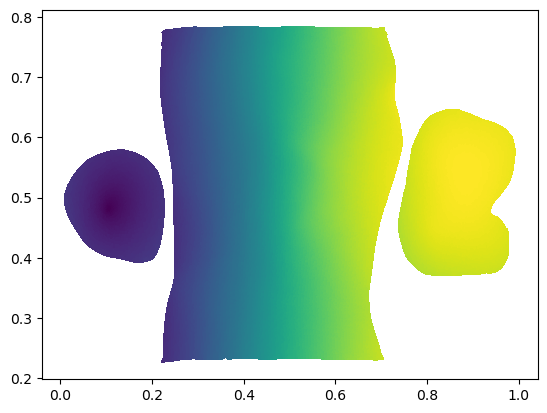

In [14]:
plt.tripcolor(*mesh.texture_vertices.T, mesh.texture_tris, eigen_vecs[matched_vertex_inds,0])

In [157]:
mesh_spectral = deepcopy(mesh)
mesh_spectral.vertices = eigen_vecs[:,:3] *np.array([11,1,1]) / np.sqrt(eigen_vals[:3])
mesh_spectral.write_obj("movie_example/spectral_final.obj")

### Functional mapping

https://people.csail.mit.edu/jsolomon/assets/fmaps.pdf . SIGGRAPH test of time award. Uses Laplace Beltrami descriptors.

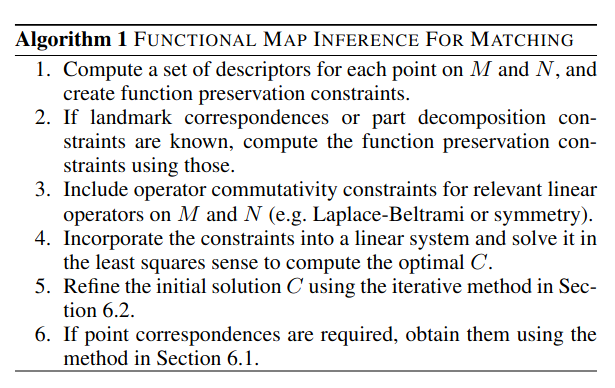

There appears to be an existing implementation in python: https://github.com/RobinMagnet/pyFM

If this works well, I will integrate it into my codebase (replace dependecies by ligigl).

Let's try out https://github.com/RobinMagnet/pyFM/blob/master/examples/mesh_and_matching/basic_functions.ipynb

It does not work that well. Ok for matching from tpt 1->2, bad for 1->20 (erroneous patches). 1->10 OK again.

20 -> 30: bad, mayn patches. I think not suitable. Also kinda slow.

Dependencies:

- numpy, scipy, tqdm, scikit-learn - all OK.
- potpourri3d (geodesic distance), robust_laplacian


As Dillon pointed out, shape descriptors of Laplace-Beltrami kind fundamentally use _metric_ information. Laplace Beltramis is equivalent to a metric. Good for isometric deformations, like joint movements, bad for non-isometric, which is standard for us.

There's also "soft shells" but that code requires pytorch etc and is not really documented: https://github.com/marvin-eisenberger/deep-shells/

In [85]:
# add tutorial option meshplot

In [9]:
from pyFM.mesh import TriMesh
from pyFM.functional import FunctionalMapping

In [22]:
import meshplot as mp

In [23]:
def plot_mesh(myMesh,cmap=None):
    mp.plot(myMesh.vertlist, myMesh.facelist,c=cmap)
    
def double_plot(myMesh1,myMesh2,cmap1=None,cmap2=None):
    d = mp.subplot(myMesh1.vertlist, myMesh1.facelist, c=cmap1, s=[2, 2, 0])
    mp.subplot(myMesh2.vertlist, myMesh2.facelist, c=cmap2, s=[2, 2, 1], data=d)

def visu(vertices):
    min_coord,max_coord = np.min(vertices,axis=0,keepdims=True),np.max(vertices,axis=0,keepdims=True)
    cmap = (vertices-min_coord)/(max_coord-min_coord)
    return cmap

In [11]:
meshes_dict[5].vertices

array([[ 301.61044312,  205.18177795,  180.58009338],
       [ 302.22671509,  200.05329895,  184.60041809],
       [ 301.53530884,  194.43106079,  189.8769989 ],
       ...,
       [ 450.80654907, 1021.80535889,  482.48751831],
       [ 451.09481812, 1020.23577881,  492.08349609],
       [ 459.08535767,  947.89038086,  546.08514404]])

In [14]:
mesh1 = TriMesh(meshes_dict[1].vertices, meshes_dict[1].tris)
mesh2 = TriMesh(meshes_dict[5].vertices, meshes_dict[5].tris)

In [16]:
# distance computation using heat geodesic  -replace potpourri backend by igl.heat_geodesic
# or igl.exact_geodesic
dists = mesh1.geod_from(1000, robust=True)

In [17]:
mesh1.process(k=100, intrinsic=True, verbose=True);

Computing 100 eigenvectors
	Done in 5.30 s


In [18]:
mesh2.process(k=100, intrinsic=True, verbose=True);

Computing 100 eigenvectors
	Done in 5.20 s


#### Compute the functional map

In [76]:
# load data

t0 = 20
t1 = 30

mesh1 = TriMesh(meshes_dict[t0].vertices, meshes_dict[t0].tris)
mesh2 = TriMesh(meshes_dict[t1].vertices, meshes_dict[t1].tris)

In [77]:
# compute descriptors

process_params = {
    'n_ev': (35,35),  # Number of eigenvalues on source and Target. - also no improvement
    'subsample_step': 5,  # In order not to use too many descriptors. makes no big difference
    'descr_type': 'WKS',  # WKS or HKS - makes no big difference
}

model = FunctionalMapping(mesh1, mesh2)
model.preprocess(**process_params,verbose=True);


Computing Laplacian spectrum
Computing 200 eigenvectors
	Done in 12.41 s
Computing 200 eigenvectors
	Done in 27.69 s

Computing descriptors
	Normalizing descriptors

	20 out of 100 possible descriptors kept


#### Fitting the transformation model

In [78]:
fit_params = {
    'w_descr': 1e0,
    'w_lap': 1e-2,
    'w_dcomm': 1e-1,
    'w_orient': 1e-2}


model.fit(**fit_params, verbose=True)

Computing commutativity operators
Computing orientation operators
	Scaling LBO commutativity weight by 3.9e+04
	Scaling orientation preservation weight by 1.2e+14

Optimization :
	35 Ev on source - 35 Ev on Target
	Using 20 Descriptors
	Hyperparameters :
		Descriptors preservation :1.0e+00
		Descriptors commutativity :1.0e-01
		Laplacian commutativity :1.0e-02
		Orientation preservation :1.2e+12

	Task : CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL, funcall : 173, nit : 162, warnflag : 0
	Done in 0.34 seconds


In [79]:
# we can already see that this has errors - bad patches if map is over larger distances
# like from tpt 1 -> 20. need w_orient >0 . Do I need more descriptors? HKS or WKS?

In [80]:
p2p_21 = model.get_p2p(n_jobs=1)
cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21]
double_plot(mesh1,mesh2,cmap1,cmap2)

#### Refining

This does improve things.

In [81]:
model.icp_refine(verbose=True)
p2p_21_icp = model.get_p2p()


  0%|          | 0/10 [00:00<?, ?it/s]

In [82]:
cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21_icp]
double_plot(mesh1,mesh2,cmap1,cmap2)

In [83]:
model.change_FM_type('classic') # We refine the first computed map, not the icp-refined one
model.zoomout_refine(nit=15, step = 1, verbose=True)
print(model.FM.shape)
p2p_21_zo = model.get_p2p()

  0%|          | 0/15 [00:00<?, ?it/s]

(50, 50)


In [84]:
cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21_zo]
double_plot(mesh1,mesh2,cmap1,cmap2)

#### Extracting the map in a usable form